<a href="https://colab.research.google.com/github/zuzanadostalova/Olympics-dataset-analysis/blob/main/Olympics_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import files

! pip install opendatasets --upgrade
import opendatasets as od

dataset_url = 'https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results'
od.download(dataset_url)

In [ ]:
df = pd.read_csv("/content/120-years-of-olympic-history-athletes-and-results/athlete_events.csv")

In [ ]:
df.head(10)

In [ ]:
df = df.drop(["ID", "Name", "Team", "Games", "City", "Event"], axis=1)

In [ ]:
df = df[df["Year"] > 1959]

In [ ]:
df['Medal'] = df['Medal'].replace(np.nan, 0)
df['Medal'].unique()
print(f'shape is {df.shape}')

shape is (209072, 9)


In [ ]:
df = df.dropna()
print(f'shape is {df.shape}')

shape is (196084, 9)


### Selecting sport categories

### Converting medal names into medal (1) or no medal (0)

In [ ]:
df = df.replace(["Gold", "Silver", "Bronze"], 1)

df.Medal.value_counts()

0    168346
1     27738
Name: Medal, dtype: int64

In [ ]:
# check most represented sports
df.value_counts('Sport')

## Winter Olympics datasets:

In [ ]:
# set Event of interst

sport_list = ["Athletics", "Swimming", "Gymnastics"]
# rename_mapper = {
#     "Figure Skating Men's Singles" : "figure_men", 
#     "Figure Skating Women's Singles"  : "figure_wom", 
#     "Speed Skating Men's 1,500 metres" : "speed_man", 
#     "Speed Skating Women's 1,500 metres" : "speed_wom"
# }

In [ ]:
setattr# filter main dataset and retrieve only categories of interest
wd_ag = df[df.Sport.isin(sport_list)].copy().reset_index()
# # rename wd_ag events
# wd_ag.replace(rename_mapper, inplace=True)
# create one hot encoding for NOC adn Event cols
noc_one = pd.get_dummies(wd_ag[["NOC", "Sport", "Sex", "Season"]])
#noc_one = pd.get_dummies(wd_ag[["Event"]])
# concat wd_ag and tmp 
tmp = pd.concat([wd_ag, noc_one], axis=1)
# calc BMI
tmp["BMI"] = tmp["Weight"] / ((tmp["Height"] / 100)** 2)
# print examples
tmp.sample(n=10)

,index,Sex,Age,Height,Weight,NOC,Year,Season,Sport,Medal,...,NOC_YUG,NOC_ZAM,NOC_ZIM,Sport_Athletics,Sport_Gymnastics,Sport_Swimming,Sex_F,Sex_M,Season_Summer,BMI
36104,155213,M,23.0,165.0,65.0,USA,1988,Summer,Athletics,0,...,0,0,0,1,0,0,0,1,1,23.875115
17337,72487,F,29.0,160.0,57.0,JAM,2016,Summer,Athletics,1,...,0,0,0,1,0,0,1,0,1,22.265625
46525,198692,F,16.0,163.0,58.0,FRG,1968,Summer,Swimming,0,...,0,0,0,0,0,1,1,0,1,21.829952
43805,187279,F,15.0,175.0,58.0,EST,2004,Summer,Swimming,0,...,0,0,0,0,0,1,1,0,1,18.938776
9263,37802,M,26.0,173.0,54.0,MEX,1992,Summer,Athletics,0,...,0,0,0,1,0,0,0,1,1,18.042701
15417,63994,M,29.0,171.0,68.0,LUX,1960,Summer,Gymnastics,0,...,0,0,0,0,1,0,0,1,1,23.255019
3196,12932,M,30.0,186.0,70.0,AUS,1988,Summer,Athletics,0,...,0,0,0,1,0,0,0,1,1,20.233553
34359,147660,M,21.0,180.0,73.0,ITA,1980,Summer,Athletics,0,...,0,0,0,1,0,0,0,1,1,22.530864
12071,48870,M,23.0,188.0,75.0,TTO,1992,Summer,Athletics,0,...,0,0,0,1,0,0,0,1,1,21.220009
29560,126635,F,20.0,164.0,51.0,FRG,1968,Summer,Gymnastics,0,...,0,0,0,0,1,0,1,0,1,18.961927


In [ ]:
# men_skating = tmp[tmp.Event =="Figure Skating Men's Singles"]
# print(f'men_skating shape is\t{men_skating.shape}')
# women_skating = tmp[tmp.Event =="Figure Skating Women's Singles"]
# print(f'women_skating shape is\t{women_skating.shape}')
# men_speed_skating = tmp[tmp.Event =="Speed Skating Men's 1,500 metres"]
# print(f'men_speed_skating shape is\t{men_speed_skating.shape}')
# women_speed_skating = tmp[tmp.Event =="Speed Skating Women's 1,500 metres"]
# print(f'women_speed_skating shape is\t{women_speed_skating.shape}')

### AutoML

In [ ]:
!pip install auto-sklearn

In [ ]:
import autosklearn.classification
import autosklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder


In [ ]:
# setting parameters for autosklearn
# generate a function to create an automl
# object
def make_automl(name_id):
  automl = autosklearn.classification.AutoSklearnClassifier(
        time_left_for_this_task=300, # limiting possible model combinations and selections to 300s == 5 mins
        per_run_time_limit=30,
        memory_limit=None,
        seed=1,
        resampling_strategy='holdout',
        resampling_strategy_arguments={
            'train_size': 0.8,
            'shuffle': True
        },
        metric=autosklearn.metrics.f1_weighted,
        scoring_functions=[
                           autosklearn.metrics.f1_weighted, 
                           autosklearn.metrics.balanced_accuracy,
                          autosklearn.metrics.precision_weighted, 
                           autosklearn.metrics.recall_weighted],
        tmp_folder=name_id
    )
  return(automl)

# get statistics
def get_metric_result(cv_results):
    results = pd.DataFrame.from_dict(cv_results)
    results = results[results['status'] == "Success"]
    cols = ['rank_test_scores', 'param_classifier:__choice__', 'mean_test_score']
    cols.extend([key for key in cv_results.keys() if key.startswith('metric_')])
    return results[cols]

In [ ]:
wdf_dict = {}
# drop cols for X
X = tmp.drop(['Medal', 'Sport', 'NOC', 'Height', 'Weight', 'index', "Sex", "Season"], axis=1).copy()
print(f'X shape is {X.shape}\tcols are { ";".join(X.columns)}')
# create labels
y = tmp['Medal']
print(f'y shape is {y.shape}')
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
print(f'X_train shape is {X_train.shape}')
print(f'y_train shape is {y_train.shape}')
print(f'X_test shape is {X_test.shape}')
print(f'y_test shape is {y_test.shape}')
# create automl object
automl_event = make_automl(f'final_sport_model_new')
# train model
automl_event.fit(X_train, y_train)
# stats
print(automl_event.sprint_statistics())
# get stats
metrics = get_metric_result(
        automl_event.cv_results_
        )
# predict to test set
predictions_sk = automl_event.predict(X_test)
# save prediction to wdf_dict
wdf_dict['predictions_sk'] = predictions_sk
# save y_test to wdf_dict
wdf_dict['y_test'] = y_test
# save train metrics
wdf_dict['metrics'] = metrics
# save model
wdf_dict['model'] = automl_event

X shape is (63041, 229)	cols are Age;Year;NOC_AFG;NOC_AHO;NOC_ALB;NOC_ALG;NOC_AND;NOC_ANG;NOC_ANT;NOC_ARG;NOC_ARM;NOC_ARU;NOC_ASA;NOC_AUS;NOC_AUT;NOC_AZE;NOC_BAH;NOC_BAN;NOC_BAR;NOC_BDI;NOC_BEL;NOC_BEN;NOC_BER;NOC_BIH;NOC_BIZ;NOC_BLR;NOC_BOL;NOC_BOT;NOC_BRA;NOC_BRN;NOC_BRU;NOC_BUL;NOC_BUR;NOC_CAF;NOC_CAM;NOC_CAN;NOC_CAY;NOC_CGO;NOC_CHA;NOC_CHI;NOC_CHN;NOC_CIV;NOC_CMR;NOC_COD;NOC_COK;NOC_COL;NOC_COM;NOC_CPV;NOC_CRC;NOC_CRO;NOC_CUB;NOC_CYP;NOC_CZE;NOC_DEN;NOC_DJI;NOC_DMA;NOC_DOM;NOC_ECU;NOC_EGY;NOC_ERI;NOC_ESA;NOC_ESP;NOC_EST;NOC_ETH;NOC_EUN;NOC_FIJ;NOC_FIN;NOC_FRA;NOC_FRG;NOC_FSM;NOC_GAB;NOC_GAM;NOC_GBR;NOC_GBS;NOC_GDR;NOC_GEO;NOC_GEQ;NOC_GER;NOC_GHA;NOC_GRE;NOC_GRN;NOC_GUA;NOC_GUI;NOC_GUM;NOC_GUY;NOC_HAI;NOC_HKG;NOC_HON;NOC_HUN;NOC_INA;NOC_IND;NOC_IOA;NOC_IRI;NOC_IRL;NOC_IRQ;NOC_ISL;NOC_ISR;NOC_ISV;NOC_ITA;NOC_IVB;NOC_JAM;NOC_JOR;NOC_JPN;NOC_KAZ;NOC_KEN;NOC_KGZ;NOC_KIR;NOC_KOR;NOC_KOS;NOC_KSA;NOC_KUW;NOC_LAO;NOC_LAT;NOC_LBA;NOC_LBR;NOC_LCA;NOC_LES;NOC_LIB;NOC_LIE;NOC_LTU;NOC_LUX;NOC_MA

In [ ]:
wdf_dict['model'].show_models()

{7: {'balancing': Balancing(random_state=1),
  'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice at 0x7f389eb05b10>,
  'cost': 0.10690972844984836,
  'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x7f389eb63a90>,
  'ensemble_weight': 1.0,
  'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice at 0x7f389eb3fbd0>,
  'model_id': 7,
  'rank': 1,
  'sklearn_classifier': RandomForestClassifier(criterion='entropy', max_features=3, min_samples_split=5,
                         n_estimators=512, n_jobs=1, random_state=1,
                         warm_start=True)}}

In [ ]:
wdf_dict['metrics'].sort_values("metric_f1_weighted", ascending=False)

,rank_test_scores,param_classifier:__choice__,mean_test_score,metric_f1_weighted,metric_balanced_accuracy,metric_precision_weighted,metric_recall_weighted
5,1,random_forest,0.893090,0.893090,0.602132,0.89195,0.911768
2,2,random_forest,0.860625,0.860625,0.500000,0.81997,0.905522


0.9133158854786264
0.5778301886792453


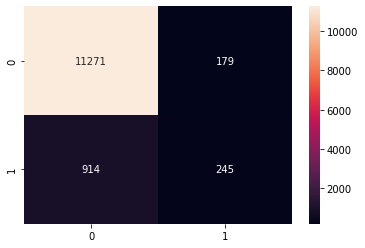

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
import seaborn as sns

classification_report(wdf_dict['y_test'], wdf_dict['predictions_sk'], output_dict=True)
cm = confusion_matrix(wdf_dict['y_test'], wdf_dict['predictions_sk'])
#tn, fp, fn, tp = confusion_matrix(wdf_dict['y_test'], wdf_dict['predictions_sk']).ravel()
#print(tn, fp, fn, tp )
print(accuracy_score(wdf_dict['y_test'], wdf_dict['predictions_sk']))
print(precision_score(wdf_dict['y_test'], wdf_dict['predictions_sk']))

sns.heatmap(cm, annot=True, fmt='d')

## Random forest feature importance:

### 1. graph from the presentation based on age, year, country, sport, sex (sex_m, sex_f), season, and bmi: 

Note: sex and season are categorical variables, therefore they were one hot encoded into new columns (Sex_F,	Sex_M, and	Season_Summer). For this reason, we need to drop the original categorical sex and season columns.

In [ ]:
X = tmp.drop(["Medal", "Sport", "NOC", "Height", "Weight", "index", "Sex", "Season"], axis=1)
print(f'X shape is {X.shape}\tcols are { ";".join(X.columns)}')
# create labels
y = tmp['Medal']
print(f'y shape is {y.shape}')
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
print(f'X_train shape is {X_train.shape}')
print(f'y_train shape is {y_train.shape}')
print(f'X_test shape is {X_test.shape}')
print(f'y_test shape is {y_test.shape}')

X shape is (63041, 229)	cols are Age;Year;NOC_AFG;NOC_AHO;NOC_ALB;NOC_ALG;NOC_AND;NOC_ANG;NOC_ANT;NOC_ARG;NOC_ARM;NOC_ARU;NOC_ASA;NOC_AUS;NOC_AUT;NOC_AZE;NOC_BAH;NOC_BAN;NOC_BAR;NOC_BDI;NOC_BEL;NOC_BEN;NOC_BER;NOC_BIH;NOC_BIZ;NOC_BLR;NOC_BOL;NOC_BOT;NOC_BRA;NOC_BRN;NOC_BRU;NOC_BUL;NOC_BUR;NOC_CAF;NOC_CAM;NOC_CAN;NOC_CAY;NOC_CGO;NOC_CHA;NOC_CHI;NOC_CHN;NOC_CIV;NOC_CMR;NOC_COD;NOC_COK;NOC_COL;NOC_COM;NOC_CPV;NOC_CRC;NOC_CRO;NOC_CUB;NOC_CYP;NOC_CZE;NOC_DEN;NOC_DJI;NOC_DMA;NOC_DOM;NOC_ECU;NOC_EGY;NOC_ERI;NOC_ESA;NOC_ESP;NOC_EST;NOC_ETH;NOC_EUN;NOC_FIJ;NOC_FIN;NOC_FRA;NOC_FRG;NOC_FSM;NOC_GAB;NOC_GAM;NOC_GBR;NOC_GBS;NOC_GDR;NOC_GEO;NOC_GEQ;NOC_GER;NOC_GHA;NOC_GRE;NOC_GRN;NOC_GUA;NOC_GUI;NOC_GUM;NOC_GUY;NOC_HAI;NOC_HKG;NOC_HON;NOC_HUN;NOC_INA;NOC_IND;NOC_IOA;NOC_IRI;NOC_IRL;NOC_IRQ;NOC_ISL;NOC_ISR;NOC_ISV;NOC_ITA;NOC_IVB;NOC_JAM;NOC_JOR;NOC_JPN;NOC_KAZ;NOC_KEN;NOC_KGZ;NOC_KIR;NOC_KOR;NOC_KOS;NOC_KSA;NOC_KUW;NOC_LAO;NOC_LAT;NOC_LBA;NOC_LBR;NOC_LCA;NOC_LES;NOC_LIB;NOC_LIE;NOC_LTU;NOC_LUX;NOC_MA

In [ ]:
X.head()

,Age,Year,NOC_AFG,NOC_AHO,NOC_ALB,NOC_ALG,NOC_AND,NOC_ANG,NOC_ANT,NOC_ARG,...,NOC_YUG,NOC_ZAM,NOC_ZIM,Sport_Athletics,Sport_Gymnastics,Sport_Swimming,Sex_F,Sex_M,Season_Summer,BMI
0,31.0,2000,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,36.393158
1,30.0,2012,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,21.733535
2,21.0,1996,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,20.724838
3,21.0,1996,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,20.724838
4,21.0,1996,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,20.724838


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_final = RandomForestClassifier(max_depth=200, random_state=42)
clf_final.fit(X_train, y_train)

RandomForestClassifier(max_depth=200, random_state=42)

In [ ]:
predictions_all_countr = clf_final.predict(X_test)

0.9066539773177889
0.48846153846153845


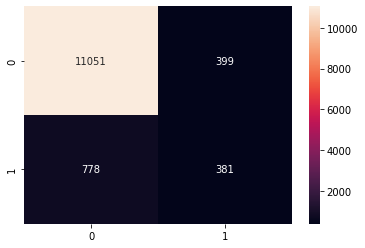

In [ ]:
cm_final = confusion_matrix(y_test, predictions_all_countr)
#tn, fp, fn, tp = confusion_matrix(wdf_dict['y_test'], wdf_dict['predictions_sk']).ravel()
#print(tn, fp, fn, tp )
print(accuracy_score(y_test, predictions_all_countr))
print(precision_score(y_test, predictions_all_countr))

sns.heatmap(cm_final, annot=True, fmt='d')

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, predictions_all_countr, average="macro")

0.671212742102931

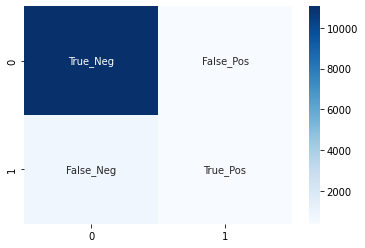

In [ ]:
labels = ["True_Neg","False_Pos","False_Neg","True_Pos"]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_final, annot=labels, fmt='', cmap='Blues')

BMI is the most important feature:

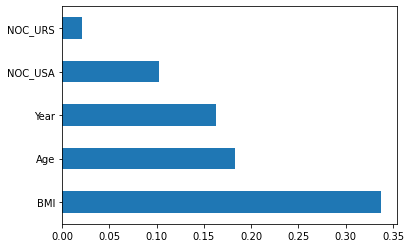

In [ ]:
feat_importances = pd.Series(clf_final.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')

### 2. graph from the presentation based on age, bmi, and sports: 

Removing features results in lower performace and lower success in discovering medal winners:

In [ ]:
X = tmp[["Age","BMI","Sport_Athletics",	"Sport_Gymnastics",	"Sport_Swimming"]]
print(f'X shape is {X.shape}\tcols are { ";".join(X.columns)}')
# create labels
y = tmp['Medal']
print(f'y shape is {y.shape}')
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
print(f'X_train shape is {X_train.shape}')
print(f'y_train shape is {y_train.shape}')
print(f'X_test shape is {X_test.shape}')
print(f'y_test shape is {y_test.shape}')

X shape is (63041, 5)	cols are Age;BMI;Sport_Athletics;Sport_Gymnastics;Sport_Swimming
y shape is (63041,)
X_train shape is (50432, 5)
y_train shape is (50432,)
X_test shape is (12609, 5)
y_test shape is (12609,)


In [ ]:
X.head()

,Age,BMI,Sport_Athletics,Sport_Gymnastics,Sport_Swimming
0,31.0,36.393158,1,0,0
1,30.0,21.733535,1,0,0
2,21.0,20.724838,0,0,1
3,21.0,20.724838,0,0,1
4,21.0,20.724838,0,0,1


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_final = RandomForestClassifier(max_depth=200, random_state=42)
clf_final.fit(X_train, y_train)

RandomForestClassifier(max_depth=200, random_state=42)

In [ ]:
predictions_all_countr = clf_final.predict(X_test)

0.8892061226108335
0.3068181818181818


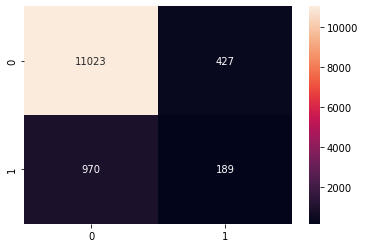

In [ ]:
cm_final = confusion_matrix(y_test, predictions_all_countr)
#tn, fp, fn, tp = confusion_matrix(wdf_dict['y_test'], wdf_dict['predictions_sk']).ravel()
#print(tn, fp, fn, tp )
print(accuracy_score(y_test, predictions_all_countr))
print(precision_score(y_test, predictions_all_countr))

sns.heatmap(cm_final, annot=True, fmt='d')

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, predictions_all_countr, average="macro")

0.576683198624413

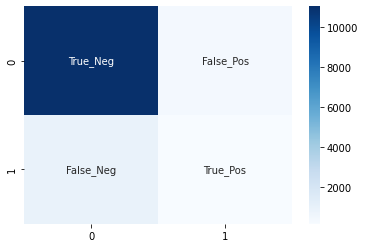

In [ ]:
labels = ["True_Neg","False_Pos","False_Neg","True_Pos"]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_final, annot=labels, fmt='', cmap='Blues')

We can see that sport category has very low feature importance:

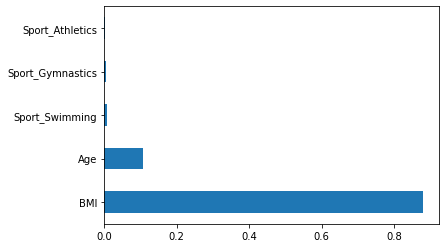

In [ ]:
feat_importances = pd.Series(clf_final.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')